<a href="https://colab.research.google.com/github/nedaa135/paython/blob/main/Path%20map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Start: [np.int64(10), np.int64(10), np.int64(0)]
Goal: [np.int64(90), np.int64(90), np.int64(0)]
Obstacles: [[20, 20, 0], [25, 25, 0], [30, 30, 0], [40, 40, 0], [45, 45, 0]] ...


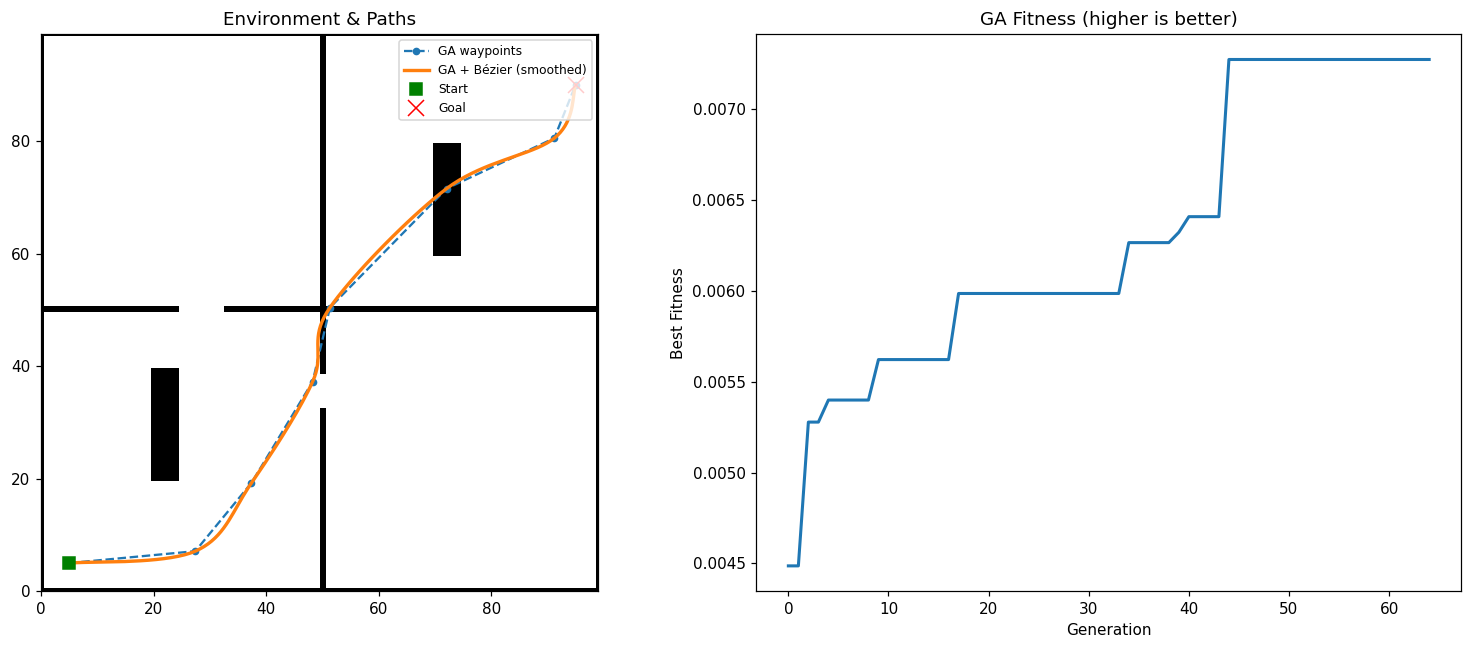

== Metrics ==
A*           : not found / blocked
GA (raw)     : length=132.99, smooth=1.510, collisions=5/70
GA + Bézier  : length=148.05, smooth=69.540, collisions=16/1330

Saved files: grid.npy, ga_waypoints_raw.npy, ga_bezier_path.npy, ga_best_fitness_curve.npy


In [5]:
# ===========================
# GA + Bezier Path Planning
# ===========================
# - Synthetic 2D grid maps with obstacles
# - GA optimizes intermediate waypoints (x,y)
# - Bézier smoothing for final path
# - Baseline: A* on the grid
# - Plots, metrics, and saved arrays
# ===========================

!pip -q install pygad

import numpy as np
import math
import random
import pygad
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
from dataclasses import dataclass
import os

# Ensure data directory exists and create dummy data files
if not os.path.exists('data'):
    os.makedirs('data')

# Create dummy map_points.csv
map_data_content = """
start_x,start_y,start_z,goal_x,goal_y,goal_z
10,10,0,90,90,0
"""
with open ('/content/data/map points.csv', 'w') as f:
    f.write(map_data_content)

# Create dummy obstacles.csv
obstacles_content = """
obstacle_x,obstacle_y,obstacle_z
20,20,0
25,25,0
30,30,0
40,40,0
45,45,0
"""
with open('/content/data/obstacles.csv', 'w') as f:
    f.write(obstacles_content)


# Load dataset
map_data = pd.read_csv("/content/data/map points.csv")
obstacles = pd.read_csv("/content/data/obstacles.csv")

# Extract start and goal
start = [
    map_data["start_x"][0],
    map_data["start_y"][0],
    map_data["start_z"][0]
]
goal = [
    map_data["goal_x"][0],
    map_data["goal_y"][0],
    map_data["goal_z"][0]
]

# Convert obstacles to list of points
obstacle_points = obstacles[["obstacle_x", "obstacle_y", "obstacle_z"]].values.tolist()

print("Start:", start)
print("Goal:", goal)
print("Obstacles:", obstacle_points[:5], "...")


# ---------------------------
# Reproducibility
# ---------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# ---------------------------
# Map / Environment
# ---------------------------
@dataclass
class EnvConfig:
    H: int = 100
    W: int = 100
    obstacle_ratio: float = 0.20  # used for random maps
    kind: str = "rooms"  # "rooms" | "maze" | "random"

def make_map(cfg: EnvConfig):
    """Generate a 2D occupancy grid: 0=free, 1=obstacle."""
    H, W = cfg.H, cfg.W
    grid = np.zeros((H, W), dtype=np.uint8)

    # Border walls
    grid[0, :] = 1
    grid[-1, :] = 1
    grid[:, 0] = 1
    grid[:, -1] = 1

    if cfg.kind == "rooms":
        # Create a few rectangular rooms with doorways
        # Vertical wall
        grid[:, W//2] = 1
        grid[H//3:(H//3)+6, W//2] = 0  # a door
        # Horizontal wall
        grid[H//2, :] = 1
        grid[H//2, W//4:(W//4)+8] = 0  # a door
        # Extra blocks
        grid[20:40, 20:25] = 1
        grid[60:80, 70:75] = 1

    elif cfg.kind == "maze":
        # Simple striped maze
        for r in range(10, H-10, 10):
            grid[r, 10:W-10] = 1
            # gaps alternate
            gap_start = 10 if (r//10) % 2 == 0 else W-20
            grid[r, gap_start:gap_start+8] = 0

    elif cfg.kind == "random":
        # Scatter rectangles
        n_rect = 15
        for _ in range(n_rect):
            h = np.random.randint(5, 15)
            w = np.random.randint(5, 15)
            r = np.random.randint(1, H-h-1)
            c = np.random.randint(1, W-w-1)
            grid[r:r+h, c:c+w] = 1

    return grid

def is_free(grid, p):
    """Check if (x,y) is free; p in float, clipped to int indices."""
    H, W = grid.shape
    x, y = int(round(p[0])), int(round(p[1]))
    if x < 0 or x >= W or y < 0 or y >= H:
        return False
    return grid[y, x] == 0

def sample_line(p0, p1, n=50):
    """Sample n points between p0 and p1 (inclusive) in float coords."""
    t = np.linspace(0, 1, n)
    pts = (1-t)[:,None]*np.array(p0) + t[:,None]*np.array(p1)
    return pts

def collision_along_polyline(grid, points, samples_per_segment=20):
    """Return collision count and total samples along a polyline."""
    total = 0
    hits = 0
    for i in range(len(points)-1):
        seg = sample_line(points[i], points[i+1], samples_per_segment)
        for p in seg:
            total += 1
            if not is_free(grid, p):
                hits += 1
    return hits, total

# ---------------------------
# A* Baseline (grid-based)
# ---------------------------
def astar(grid, start, goal):
    """A* on a 4-connected grid. start/goal are integer (x,y)."""
    H, W = grid.shape
    sx, sy = start
    gx, gy = goal
    if not is_free(grid, start) or not is_free(grid, goal):
        return None

    # Heuristic: Euclidean
    def h(a, b):
        return math.hypot(a[0]-b[0], a[1]-b[1])

    open_set = set()
    came_from = {}
    gscore = {}
    fscore = {}

    start_t = (sx, sy)
    goal_t = (gx, gy)
    open_set.add(start_t)
    gscore[start_t] = 0
    fscore[start_t] = h(start_t, goal_t)

    dirs = [(1,0),(-1,0),(0,1),(0,-1)]
    while open_set:
        current = min(open_set, key=lambda n: fscore.get(n, float('inf')))
        if current == goal_t:
            # reconstruct path
            path = [current]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            path.reverse()
            return [(float(x), float(y)) for x,y in path]

        open_set.remove(current)
        cx, cy = current
        for dx, dy in dirs:
            nx, ny = cx+dx, cy+dy
            if nx<0 or nx>=W or ny<0 or ny>=H or grid[ny,nx]==1:
                continue
            ng = gscore[current] + 1.0
            if ng < gscore.get((nx,ny), float('inf')):
                came_from[(nx,ny)] = current
                gscore[(nx,ny)] = ng
                fscore[(nx,ny)] = ng + h((nx,ny), goal_t)
                if (nx,ny) not in open_set:
                    open_set.add((nx,ny))
    return None

# ---------------------------
# Geometry helpers
# ---------------------------
def polyline_length(points):
    return sum(math.hypot(points[i+1][0]-points[i][0], points[i+1][1]-points[i][1])
               for i in range(len(points)-1))

def turning_smoothness(points):
    """Sum of squared turn angles (smaller is smoother)."""
    if len(points) < 3: return 0.0
    total = 0.0
    for i in range(1, len(points)-1):
        a = np.array(points[i]) - np.array(points[i-1])
        b = np.array(points[i+1]) - np.array(points[i])
        la = np.linalg.norm(a); lb = np.linalg.norm(b)
        if la < 1e-6 or lb < 1e-6:
            continue
        cosang = np.clip(np.dot(a,b)/(la*lb), -1.0, 1.0)
        ang = math.acos(cosang)
        total += ang*ang
    return total

# ---------------------------
# Bézier smoothing
# Convert a polyline to chained cubic Bézier segments by estimating tangents
# (Catmull–Rom to Bezier conversion with tension t=1/6).
# ---------------------------
def cubic_bezier_control_points(poly, t=1/6):
    """Return cubic Bezier segments [(P0,C1,C2,P3), ...] from a polyline."""
    n = len(poly)
    if n < 2:
        return []
    # For endpoints, duplicate neighbors
    P = [np.array(p, dtype=float) for p in poly]
    bz = []
    for i in range(n-1):
        Pm1 = P[i-1] if i-1 >= 0 else P[i]
        P0  = P[i]
        P1  = P[i+1]
        P2  = P[i+2] if i+2 < n else P[i+1]
        C1 = P0 + t*(P1 - Pm1)
        C2 = P1 - t*(P2 - P0)
        bz.append((P0, C1, C2, P1))
    return bz

def sample_cubic_bezier(seg, n=20):
    P0, C1, C2, P3 = seg
    t = np.linspace(0,1,n)
    pts = ( (1-t)**3)[:,None]*P0 + 3*((1-t)**2*t)[:,None]*C1 + 3*((1-t)*t**2)[:,None]*C2 + (t**3)[:,None]*P3
    return [tuple(p) for p in pts]

def sample_bezier_path(poly, samples_per_seg=20):
    segs = cubic_bezier_control_points(poly, t=1/6)
    if not segs:
        return poly
    pts = []
    for s in segs:
        S = sample_cubic_bezier(s, n=samples_per_seg)
        if pts:
            # drop duplicate first point
            pts.extend(S[1:])
        else:
            pts.extend(S)
    return pts

# ---------------------------
# GA encoding
# - Genome encodes K intermediate waypoints as normalized coords in [0,1]
# - Decoding maps them to (x,y) inside the free-space bounds (with padding)
# ---------------------------
@dataclass
class GAConfig:
    K: int = 6                  # number of intermediate waypoints
    generations: int = 80
    pop_size: int = 120
    mutation_prob: float = 0.2
    crossover_prob: float = 0.9

def decode_genome(genome, grid, start, goal, margin=3):
    H, W = grid.shape
    xs = []
    ys = []
    for i in range(0, len(genome), 2):
        # map [0,1] → valid interior box [margin, W-margin)
        x = margin + (W-2*margin-1) * np.clip(genome[i], 0, 1)
        y = margin + (H-2*margin-1) * np.clip(genome[i+1], 0, 1)
        xs.append(x); ys.append(y)
    pts = [tuple(start)] + list(zip(xs, ys)) + [tuple(goal)]
    return pts

def clamp_to_free(grid, p):
    """If p is in obstacle, walk to nearest free cell (small radius)."""
    x, y = int(round(p[0])), int(round(p[1]))
    if is_free(grid, (x,y)):
        return (float(x), float(y))
    H, W = grid.shape
    for r in range(1, 6):
        for dy in range(-r, r+1):
            for dx in range(-r, r+1):
                nx, ny = x+dx, y+dy
                if 0<=nx<W and 0<=ny<H and grid[ny, nx]==0:
                    return (float(nx), float(ny))
    return (float(x), float(y))

def cost_of_polyline(grid, pts, w_len=1.0, w_smooth=0.15, w_coll=50.0):
    """Compute cost = length + smoothness + collision penalty."""
    # Optionally snap any internal waypoint that is inside obstacles
    poly = [pts[0]] + [clamp_to_free(grid, p) for p in pts[1:-1]] + [pts[-1]]

    L = polyline_length(poly)
    S = turning_smoothness(poly)
    hits, total = collision_along_polyline(grid, poly, samples_per_segment=10)
    coll_rate = hits / max(1, total)

    return w_len*L + w_smooth*S + w_coll*coll_rate, {"L":L, "S":S, "hits":hits, "samples":total}

# ---------------------------
# Experiment setup
# ---------------------------
cfg = EnvConfig(H=100, W=100, kind="rooms")   # try: "maze", "random"
grid = make_map(cfg)

start = (5, 5)
goal  = (95, 90)

# ensure start/goal are free (move slightly if blocked)
start = clamp_to_free(grid, start)
goal  = clamp_to_free(grid, goal)

# Baseline A*
astar_path = astar(grid, (int(start[0]),int(start[1])), (int(goal[0]),int(goal[1])))

# ---------------------------
# GA Fitness
# ---------------------------
ga_cfg = GAConfig(K=6, generations=80, pop_size=120, mutation_prob=0.2, crossover_prob=0.9)

def fitness_func(ga_instance, solution, sol_idx):
    # solution is length = 2*K in [0,1]
    pts = decode_genome(solution, grid, start, goal, margin=3)
    # Optional: Bezier smoothing for collision checking (or use raw poly)
    # Here we evaluate fitness on the raw polyline for stricter obstacle penalties
    cost, parts = cost_of_polyline(grid, pts, w_len=1.0, w_smooth=0.15, w_coll=60.0)
    # pygad maximizes fitness → invert cost
    return 1.0/(cost + 1e-6)

num_genes = ga_cfg.K * 2

ga_instance = pygad.GA(
    num_generations=ga_cfg.generations,
    sol_per_pop=ga_cfg.pop_size,
    num_genes=num_genes,
    init_range_low=0.0,
    init_range_high=1.0,
    gene_space={'low':0.0, 'high':1.0},
    fitness_func=fitness_func,
    parent_selection_type="rws",
    num_parents_mating=2,
    crossover_type="single_point",
    crossover_probability=ga_cfg.crossover_prob,
    mutation_type="random",
    mutation_probability=ga_cfg.mutation_prob,
    allow_duplicate_genes=True,
    stop_criteria=["saturate_20"]  # early stop if not improving
)

ga_instance.run()
best_sol, best_fit, _ = ga_instance.best_solution()

# Decode + Bezier-smooth final result
raw_pts = decode_genome(best_sol, grid, start, goal, margin=3)
bezier_pts = sample_bezier_path(raw_pts, samples_per_seg=20)

# Evaluate metrics
raw_cost, raw_parts = cost_of_polyline(grid, raw_pts)
bez_cost, bez_parts = cost_of_polyline(grid, bezier_pts)

# ---------------------------
# Plot
# ---------------------------
fig, ax = plt.subplots(1, 2, figsize=(14, 6), dpi=110)

# Left: Map + paths
ax[0].imshow(grid, cmap='gray_r', origin='lower')
ax[0].plot([p[0] for p in raw_pts], [p[1] for p in raw_pts], '--o', lw=1.5, ms=4, label='GA waypoints')
ax[0].plot([p[0] for p in bezier_pts], [p[1] for p in bezier_pts], '-', lw=2.2, label='GA + Bézier (smoothed)')
if astar_path is not None:
    ax[0].plot([p[0] for p in astar_path], [p[1] for p in astar_path], '-', lw=1.5, label='A* baseline')
ax[0].plot(start[0], start[1], 'gs', ms=8, label='Start')
ax[0].plot(goal[0], goal[1], 'rx', ms=10, label='Goal')
ax[0].set_title("Environment & Paths")
ax[0].legend(loc='upper right', fontsize=8)
ax[0].set_xlim(0, grid.shape[1]-1)
ax[0].set_ylim(0, grid.shape[0]-1)

# Right: Convergence
ax[1].plot(ga_instance.best_solutions_fitness, lw=2)
ax[1].set_title("GA Fitness (higher is better)")
ax[1].set_xlabel("Generation")
ax[1].set_ylabel("Best Fitness")

plt.tight_layout()
plt.show()

# ---------------------------
# Print Metrics
# ---------------------------
def fmt(parts):
    return f"length={parts['L']:.2f}, smooth={parts['S']:.3f}, collisions={parts['hits']}/{parts['samples']}"

print("== Metrics ==")
if astar_path is not None:
    a_len = polyline_length(astar_path)
    a_smo = turning_smoothness(astar_path)
    a_hits, a_samp = collision_along_polyline(grid, astar_path)
    print(f"A*           : length={a_len:.2f}, smooth={a_smo:.3f}, collisions={a_hits}/{a_samp}")
else:
    print("A*           : not found / blocked")

print(f"GA (raw)     : {fmt(raw_parts)}")
print(f"GA + Bézier  : {fmt(bez_parts)}")

# Save outputs (optional)
np.save("grid.npy", grid)
np.save("ga_waypoints_raw.npy", np.array(raw_pts))
np.save("ga_bezier_path.npy", np.array(bezier_pts))
np.save("ga_best_fitness_curve.npy", np.array(ga_instance.best_solutions_fitness))

print("\nSaved files: grid.npy, ga_waypoints_raw.npy, ga_bezier_path.npy, ga_best_fitness_curve.npy")